In [1]:
# Load required tudatpy modules
import numpy as np
from matplotlib import pyplot as plt
from tudatpy.interface import spice
from tudatpy.kernel import constants
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.math import interpolators
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup, environment, propagation_setup, estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.numerical_simulation.environment import Tle
from datetime import datetime, timedelta


from my_functions import sat_prop, tle_epoch_to_datetime, compute_tle_checksum,sat_prop_two_body, state_eci_to_radec, sat_prop_with_stm, measurement_model, getGammaMatrix

spice.load_standard_kernels()

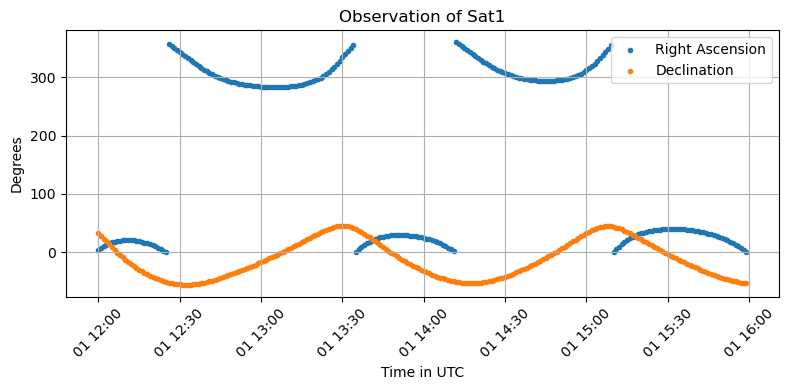

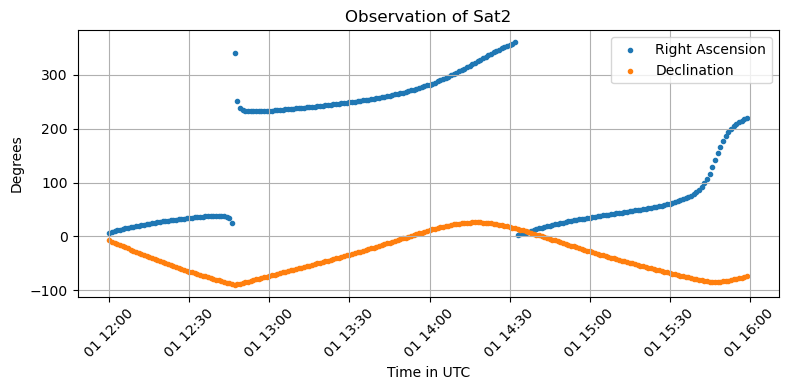

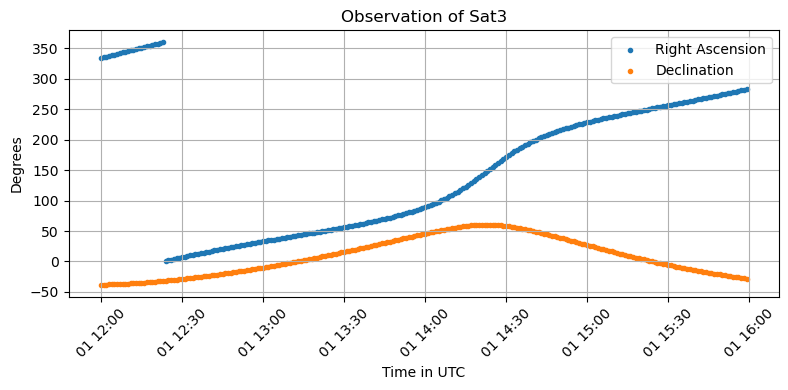

In [2]:
targets = ["Sat1","Sat2","Sat3"]

station_name ='REY30' 
geodetic_position = {'REY30': [3058.789875087734,20.709152020592995, -156.2600015424928]}

# Select the global frame and orientation 
global_frame_origin = 'Earth'
global_frame_orientation = 'J2000'

time_format = '%Y-%m-%d %H:%M:%S'

# Time window corresponding to Heavens Above data
start_epoch_string = "2025-05-26 12:00:00"
end_epoch_string = "2025-05-26 16:00:00"

time_step_seconds = 60

# Get start and end time in UTS, Julian Day and seconds since J2000
jd_start_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(start_epoch_string, time_format))
jd_end_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(end_epoch_string, time_format))
time_buffer = 0

utc_simulation_start_epoch = time_conversion.julian_day_to_calendar_date(jd_start_epoch - time_buffer)
utc_simulation_end_epoch = time_conversion.julian_day_to_calendar_date(jd_end_epoch + time_buffer)

sim_seconds_start_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_start_epoch - time_buffer)
sim_seconds_end_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_end_epoch + time_buffer)

sim_seconds_start_epoch = 0.0
sim_seconds_end_epoch = 14400.0 

bodies_to_create = ["Earth","Sun","Moon"]
central_bodies = ["Earth"]

# Creating Earth settings
body_settings = environment_setup.get_default_body_settings_time_limited(bodies_to_create, sim_seconds_start_epoch, sim_seconds_end_epoch, global_frame_origin, global_frame_orientation)
for target in targets:
    body_settings.add_empty_settings(target)
    body_settings.add_empty_settings(target+"_est")
   
# Add Earth Shape settings
eq_rad = 6378*1e3 # in meters
flat = 1/298
body_settings.get('Earth').shape_settings = environment_setup.shape.oblate_spherical(equatorial_radius = eq_rad,flattening = flat,)

# Add Earth Rotation model
body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
    environment_setup.rotation_model.iau_2006, global_frame_orientation,
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60))

initial_state_targets = dict()

initial_state_targets[targets[0]] = 1.0e+06 * np.array([0.7577,5.222607,4.8515,0.00221321,0.00467834,-0.0053713]) 
initial_state_targets[targets[1]] = np.array([ 6.06900255e+06,  6.09157542e+06,  1.05883186e+06, -1.25648342e+03, 3.83516911e+03, -5.98898761e+03])
initial_state_targets[targets[2]] = np.array([ 1.08574907e+07, -1.91497330e+06, -1.01709279e+07,  1.80075931e+03,  4.71821217e+03,  1.03397421e+03])
# initial_state_targets[targets[1]] = 1.0e+06 * np.array([4.8515,0.7577,5.222607,-0.0053713,0.00221321,0.00467834]) 
# initial_state_targets[targets[2]] = 1.0e+06 * np.array([5.222607,0.7577,4.8515,0.00467834,0.00221321,-0.0053713]) 


# Get true propogated satellite coordinates from tudat propogator
true_states = dict()
for target in targets:
    # true_states[target] = sat_prop(sim_seconds_start_epoch, sim_seconds_end_epoch-time_step_seconds, target, tles[target],fixed_step_size=60)
    true_states[target] = sat_prop(sim_seconds_start_epoch, sim_seconds_end_epoch-time_step_seconds, target, target_TLE=None,target_initial_state=initial_state_targets[target],fixed_step_size=time_step_seconds)
    # true_states[target] = sat_prop_two_body(sim_seconds_start_epoch, sim_seconds_end_epoch-60, target,target_initial_state=initial_state_targets[target])
    

# 1) Build a dict-of-dicts of ephemeris samples:
targets_states_dicts = {
    target: {
        float(row[0]): row[1:].reshape((6,1))
        for row in state
    }
    for target, state in true_states.items()
}

# 2) Assign each one into your body_settings:
for target, state in targets_states_dicts.items():
    body_settings.get(target).ephemeris_settings = environment_setup.ephemeris.tabulated(state,global_frame_origin,global_frame_orientation)

# Set up ground station settings
gs_alt_m = geodetic_position[station_name][0]
gs_lat_deg = geodetic_position[station_name][1]
gs_lon_deg = geodetic_position[station_name][2]

gs_ecef = [-5466071, -2403990,  2242473]
gs_eci = {}

gs_settings = []
gs_settings.append(environment_setup.ground_station.basic_station(
    station_name,[gs_alt_m,np.deg2rad(gs_lat_deg),np.deg2rad(gs_lon_deg)],element_conversion.geodetic_position_type))

body_settings.get('Earth').ground_station_settings = gs_settings

bodies = environment_setup.create_system_of_bodies(body_settings)

earth_rotation_model = bodies.get('Earth').rotation_model

true_radec = {}
true_state_initial_prop = {}

for target,state in targets_states_dicts.items():
    true_radec[target] = {}
    true_state_initial_prop[target] = {}
    
    for t in targets_states_dicts[target].keys():

        # Use RotationalEphemeris to get rotation matrix
        R_fixed_to_inertial = earth_rotation_model.body_fixed_to_inertial_rotation(t)

        # Apply rotation to get ECI position
        gs_eci[t] = R_fixed_to_inertial @ gs_ecef
    
        ra,dec = state_eci_to_radec(state[t].reshape(6,),gs_eci[t])
        true_radec[target][t] = [ra,dec]
        true_state_initial_prop[target][t] = [state[t]]

    times = []
    times_utc = []
    for t in sorted(true_radec[target].keys()):
        times.append(t)
        time_change_jd = time_conversion.seconds_since_epoch_to_julian_day(t)
        time_change_utc = time_conversion.julian_day_to_calendar_date(time_change_jd)
        times_utc.append(time_change_utc)


    ras = [np.rad2deg(true_radec[target][t][0]) % 360 for t in times]  # RA in degrees, wrapped
    decs = [np.rad2deg(true_radec[target][t][1]) for t in times]       # Dec in degrees

    plt.figure(figsize=(8, 4))
    plt.scatter(times_utc,ras,marker='.',label='Right Ascension')
    plt.scatter(times_utc,decs,marker='.',label='Declination')
    plt.title('Observation of '+target)
    plt.xlabel('Time in UTC')
    plt.ylabel('Degrees')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


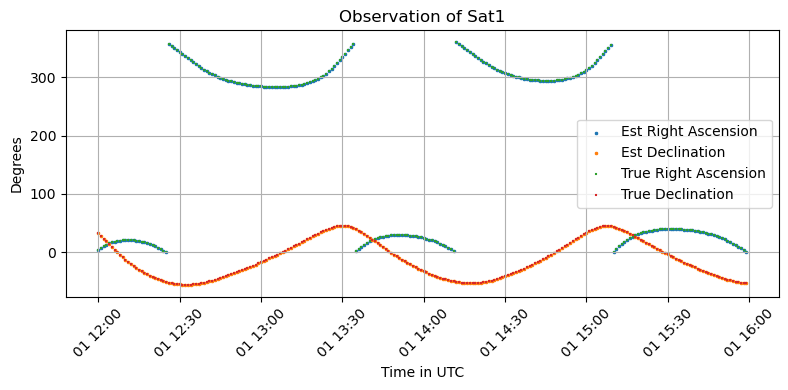

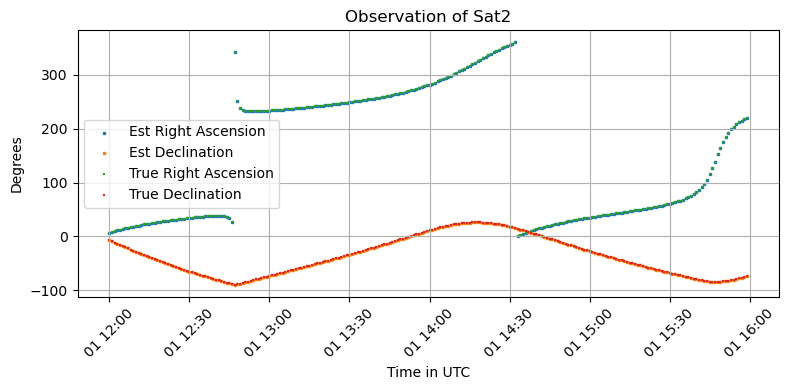

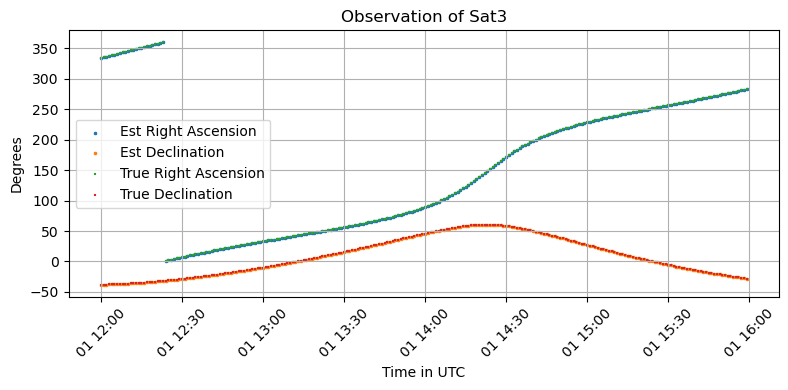

In [ ]:
# Noise matrices
q_pos = 1e-15    # km^2
Q = np.eye(3) * q_pos  # km^2
R = np.diag([1e-10 * 0.235043863818291, 1e-10 * 0.235043863818291])   # rad^2
R_std = np.sqrt(R[0][0])

converged = 1

est_state = {target: dict() for target in targets}
true_state = {target: dict() for target in targets}
est_cov   = {target: dict() for target in targets}
est_ra    = {target: dict() for target in targets}  # will store in radians
est_dec    = {target: dict() for target in targets}
true_ra_deg    = {target: dict() for target in targets}
true_dec_deg    = {target: dict() for target in targets}
resids    = {target: dict() for target in targets}

Xref_Stm0 = {}
x_true = {}
for target in targets:
    Xref_Stm0[target] = {}
    x_true[target] = initial_state_targets[target] / 1000        # km
    Xref_Stm0[target]["Xref"] = x_true[target]   # km
    Xref_Stm0[target]["Phi0"] = np.eye(6)        # unitless
    
station_id = ('Earth', station_name)

for target in targets:
    t_pre = times[0]
    xhat_k_prev = np.zeros(6)
    P_est = np.diag([1e2,1e2,1e2,1e-4,1e-4,1e-4])    # km^2

    for idx,t in enumerate(times):
        tk = times[idx]

        # True propagation 
        if idx == 0:
            x_true[target] = Xref_Stm0[target]["Xref"]   # km
        else:
            # prop_temp = sat_prop(t_pre,tk,target,target_TLE= None, target_initial_state=x_true[target])
            # x_true[target] = prop_temp[-1][1:]

            # 2 Body propagation
            prop_temp,_ = sat_prop_two_body(t_pre,tk,target,x_true[target]*1000,fixed_step_size=time_step_seconds)
            x_true[target] = list(prop_temp.values())[-1].flatten() / 1000

        # True angles
        # temp_true_ra_rad = (true_radec[target][t][0])
        # temp_true_dec_rad = (true_radec[target][t][1])

        temp_true_ra_rad,temp_true_dec_rad = state_eci_to_radec(x_true[target],gs_eci[tk]/1000)
        # Observation
        zk = np.array([temp_true_ra_rad, temp_true_dec_rad]) + np.random.normal(0, R_std, size=2)
        
        # Prediction
        if idx == 0:
            Xref_k = Xref_Stm0[target]["Xref"]
            Phi_k = Xref_Stm0[target]["Phi0"]
        else:
            # 2 body dynamics
            temp_state,stm_k = sat_prop_two_body(t_pre,tk,target,Xref_prev*1000,fixed_step_size=time_step_seconds)
            Xref_k = list(temp_state.values())[-1].flatten() / 1000
            Phi_k = list(stm_k.values())[-1]  # 6x6 matrix

            # # Full force model
            # temp_state,stm_k = sat_prop_with_stm(t,t+time_step_seconds,target,Xref_prev,fixed_step_size=60)
            # Xref_k = list(temp_state.values())[-1].flatten()
            # Phi_k = list(stm_k.values())[-1]  # 6x6 matrix
        

        Gammak = getGammaMatrix(t_pre, tk)  
        xhat_k_kminus1 = Phi_k @ xhat_k_prev
        P_k_kminus1 = Phi_k @ P_est @ Phi_k.T + Gammak @ Q @ Gammak.T


        # EKF update
        gk,H_matrix = measurement_model(Xref_k,gs_eci[t]/1000)   # Both arguments in km
        yk = zk - gk
        S_cov = H_matrix @ P_k_kminus1 @ H_matrix.T + R
        Kk = P_k_kminus1 @ H_matrix.T @ np.linalg.inv(S_cov)

        xhat_k = xhat_k_kminus1 + Kk @ (yk - H_matrix @ xhat_k_kminus1)
        P_est = (np.eye(6) - Kk @ H_matrix) @ P_k_kminus1 @ (np.eye(6) - Kk @ H_matrix).T + Kk @ R @ Kk.T
        x_est = Xref_k + xhat_k

        resids_temp = yk - H_matrix @ xhat_k

        # Setting values for next iteration
        if np.linalg.norm(xhat_k) > converged:
            Xref_k = x_est
            xhat_k = np.zeros(6)
            
        Xref_prev = Xref_k
        xhat_k_prev = xhat_k
        t_pre = tk
     
        ra_post,dec_post = state_eci_to_radec(x_est,gs_eci[t]/1000)

        # Storing stuff
        true_state[target][idx] = x_true[target]
        est_state[target][idx] = x_est
        est_cov[target][idx] = P_est
        est_ra[target][idx] = (np.rad2deg(ra_post) % 360)
        est_dec[target][idx] = (np.rad2deg(dec_post))
        true_ra_deg[target][idx] = np.rad2deg(temp_true_ra_rad) % 360
        true_dec_deg[target][idx] = np.rad2deg(temp_true_dec_rad)
        resids[target][idx] = resids_temp

    plt.figure(figsize=(8, 4))
    plt.scatter(times_utc,est_ra[target].values(),marker='x',s=3,label='Est Right Ascension')
    plt.scatter(times_utc,est_dec[target].values(),marker='x',s=3,label='Est Declination')
    plt.scatter(times_utc,true_ra_deg[target].values(),marker='+',s=3,label='True Right Ascension')
    plt.scatter(times_utc,true_dec_deg[target].values(),marker='+',s=3,label='True Declination')
    plt.title('Observation of '+target)
    plt.xlabel('Time in UTC')
    plt.ylabel('Degrees')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

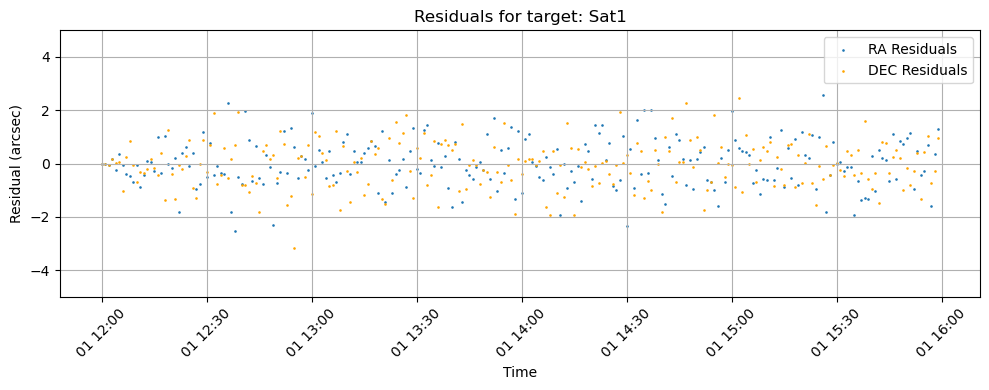

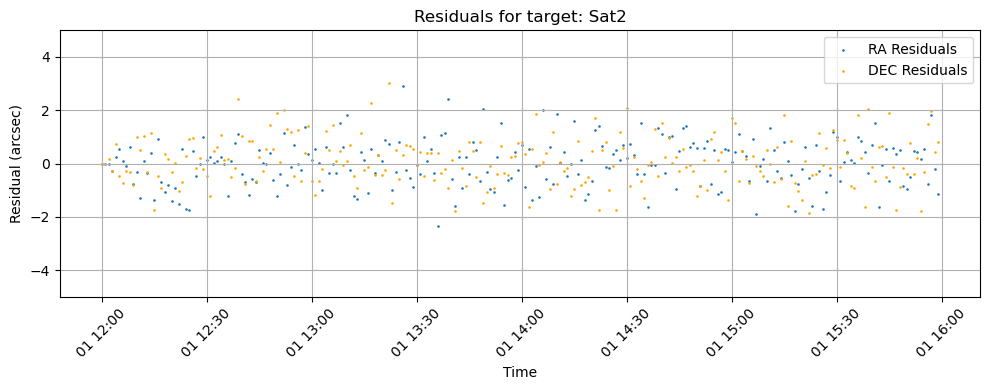

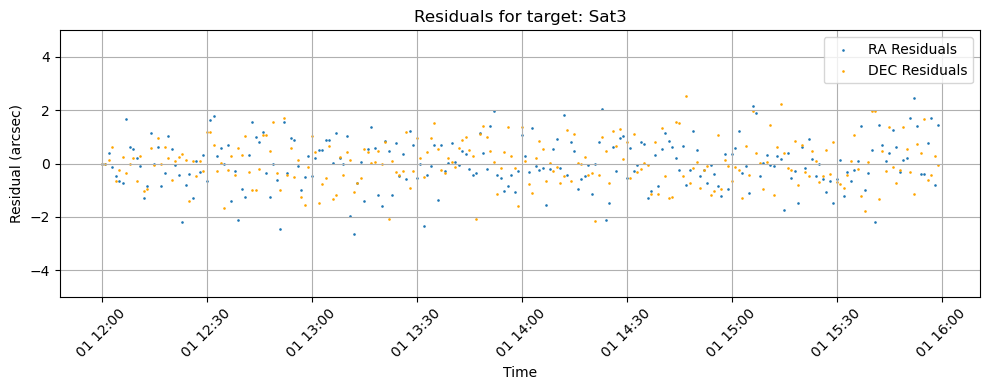

In [4]:
for target in targets:

    idxs = sorted(resids[target].keys())

    residual_array = np.array([resids[target][i] for i in idxs])  # shape (N, 2)

    # Split into RA and DEC residuals
    ra_residuals = residual_array[:, 0] * 3600
    dec_residuals = residual_array[:, 1] * 3600


    plt.figure(figsize=(10, 4))

    plt.scatter(times_utc, np.rad2deg(ra_residuals),marker='.',s=3, label="RA Residuals")
    plt.scatter(times_utc, np.rad2deg(dec_residuals),marker='.',s=3, label="DEC Residuals", color='orange')
    plt.ylabel("Residual (arcsec)")
    plt.xlabel("Time")
    plt.ylim([-5, 5])
    plt.grid(True)
    plt.legend()
    plt.title(f"Residuals for target: {target}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



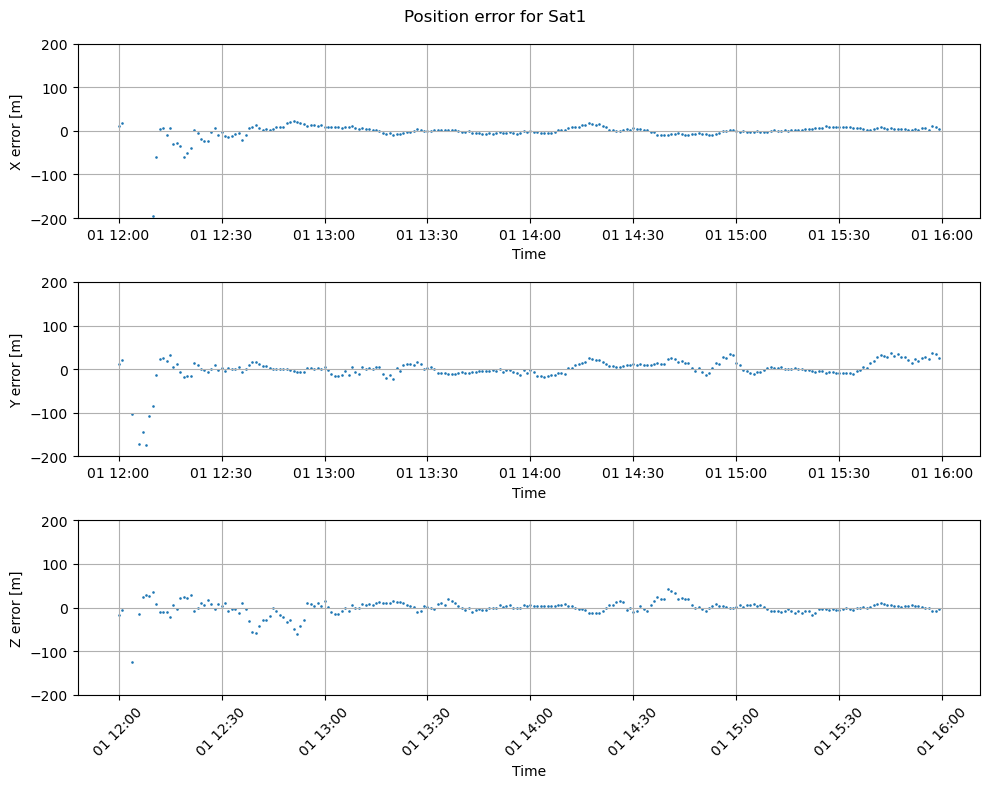

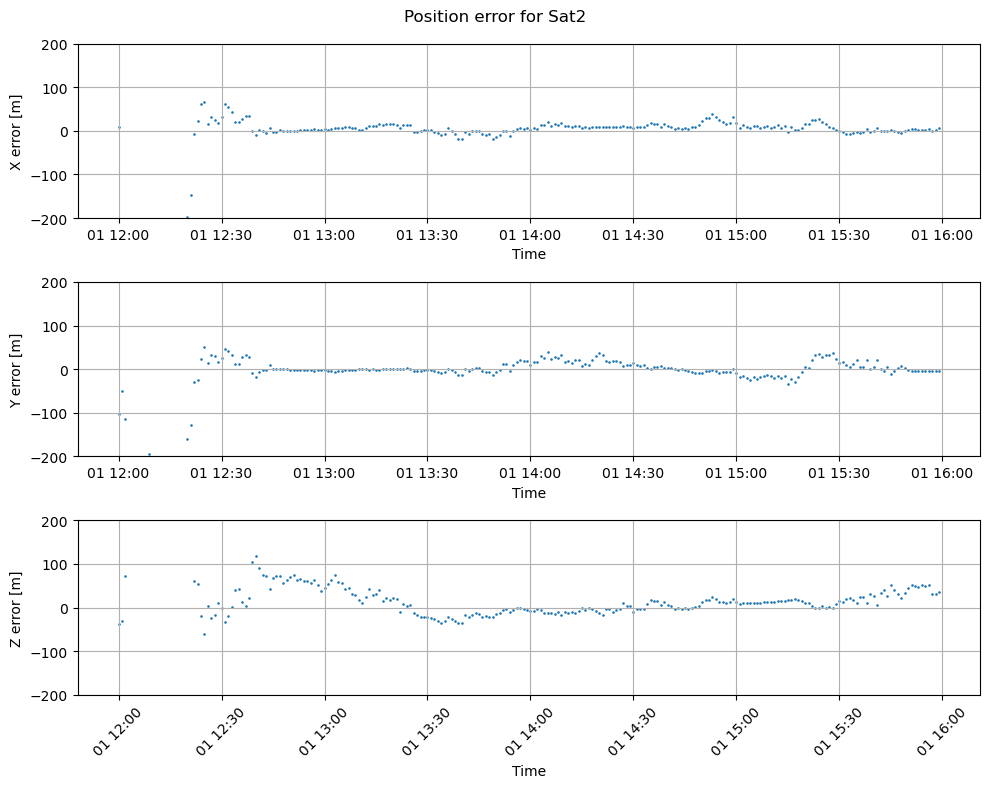

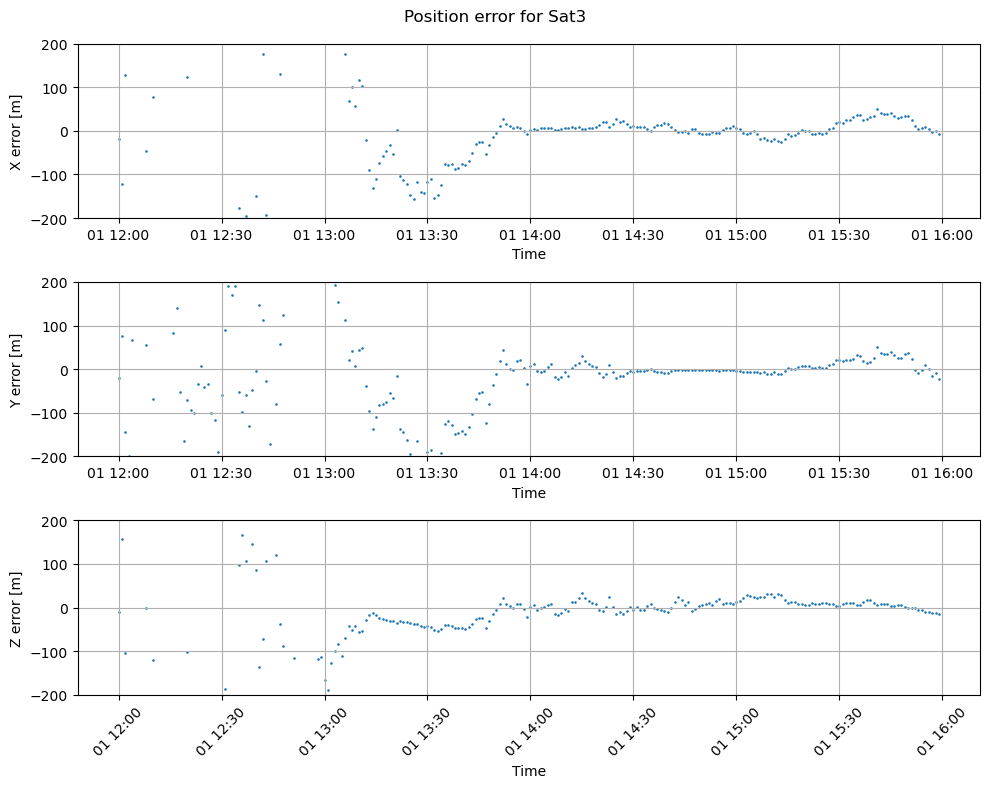

In [5]:
for target in targets:
    true_state_array = np.array([true_state[target][i] for i in idxs]) 
    est_state_array = np.array([est_state[target][i] for i in idxs])  

    er_state = (true_state_array - est_state_array) * 1000
    x_err = er_state[:,0]
    y_err = er_state[:,1]
    z_err = er_state[:,2]


    plt.figure(figsize=(10, 8))

    plt.subplot(3, 1, 1)
    plt.scatter(times_utc, (x_err),marker='.',s=3, label="X error")
    plt.ylabel("X error [m]")
    plt.xlabel("Time")
    plt.grid(True)
    plt.ylim([-200, 200])

    plt.subplot(3, 1, 2)
    plt.scatter(times_utc, (y_err),marker='.',s=3, label="Y error")
    plt.ylabel("Y error [m]")
    plt.xlabel("Time")
    plt.grid(True)
    plt.ylim([-200, 200])

    plt.subplot(3, 1, 3)
    plt.scatter(times_utc, (z_err),marker='.',s=3, label="Z error")
    plt.ylabel("Z error [m]")
    plt.xlabel("Time")
    plt.grid(True)
    plt.ylim([-200, 200])

    plt.suptitle(f"Position error for {target}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

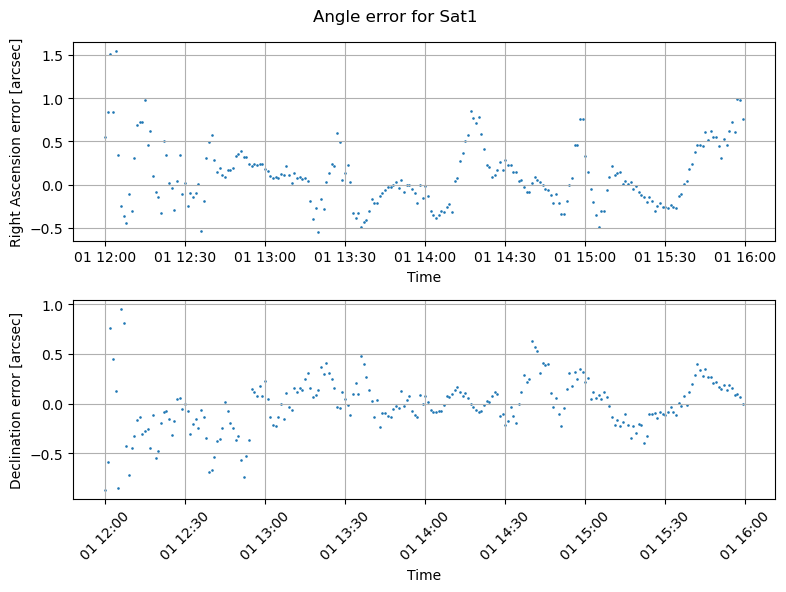

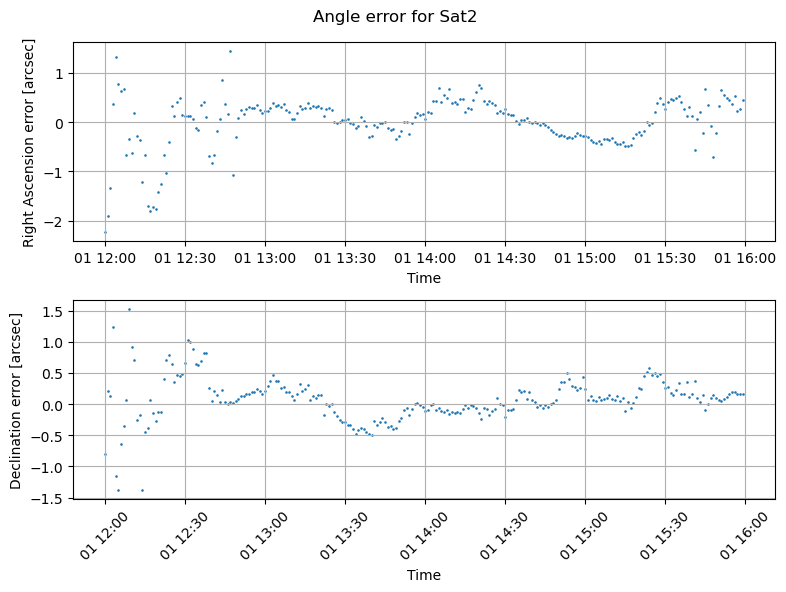

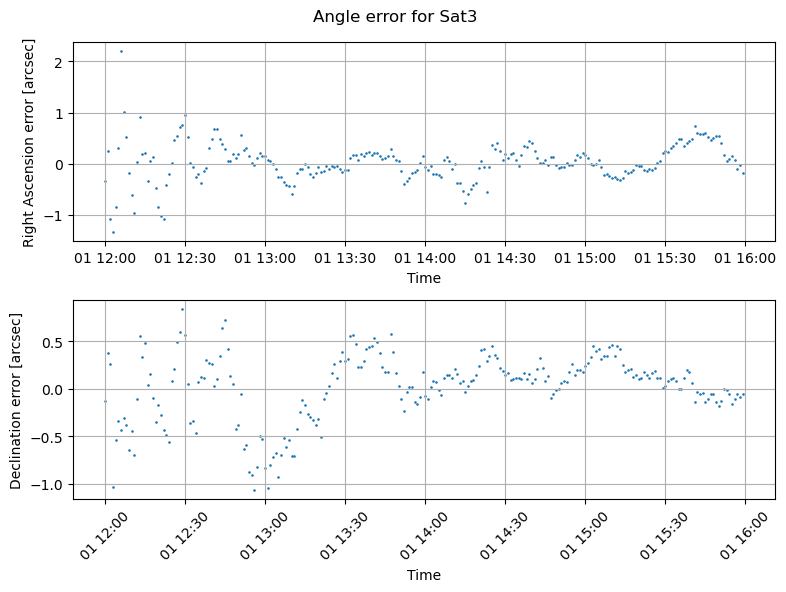

In [8]:
for target in targets:
    true_ra_array = np.array([true_ra_deg[target][i] for i in idxs]) 
    true_dec_array = np.array([true_dec_deg[target][i] for i in idxs]) 
    est_ra_array = np.array([(est_ra[target][i]) for i in idxs]) 
    est_dec_array = np.array([(est_dec[target][i]) for i in idxs])  

    ra_err = (true_ra_array - est_ra_array) * 3600
    dec_err = (true_dec_array - est_dec_array) * 3600

    plt.figure(figsize=(8, 6))

    plt.subplot(2, 1, 1)
    plt.scatter(times_utc, (ra_err),marker='.',s=3, label="Ra error")
    plt.ylabel("Right Ascension error [arcsec]")
    plt.xlabel("Time")
    plt.grid(True)
    # plt.ylim([-20, 20])

    plt.subplot(2, 1, 2)
    plt.scatter(times_utc, (dec_err),marker='.',s=3, label="Dec error")
    plt.ylabel("Declination error [arcsec]")
    plt.xlabel("Time")
    plt.grid(True)

    plt.suptitle(f"Angle error for {target}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

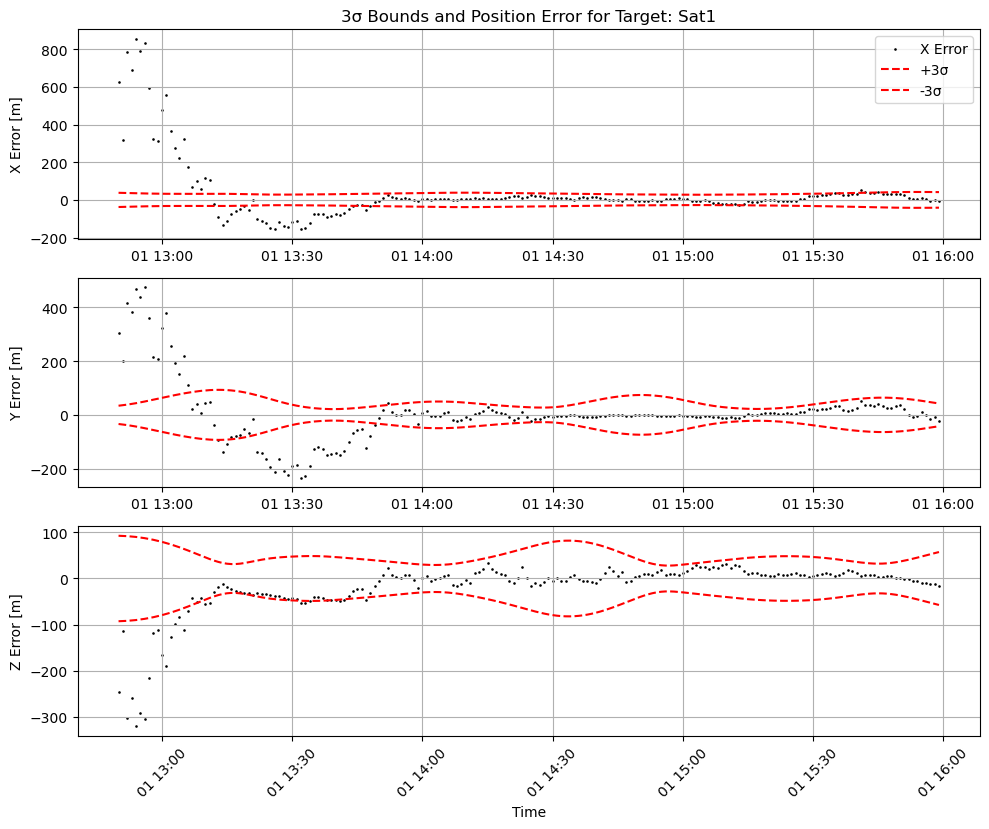

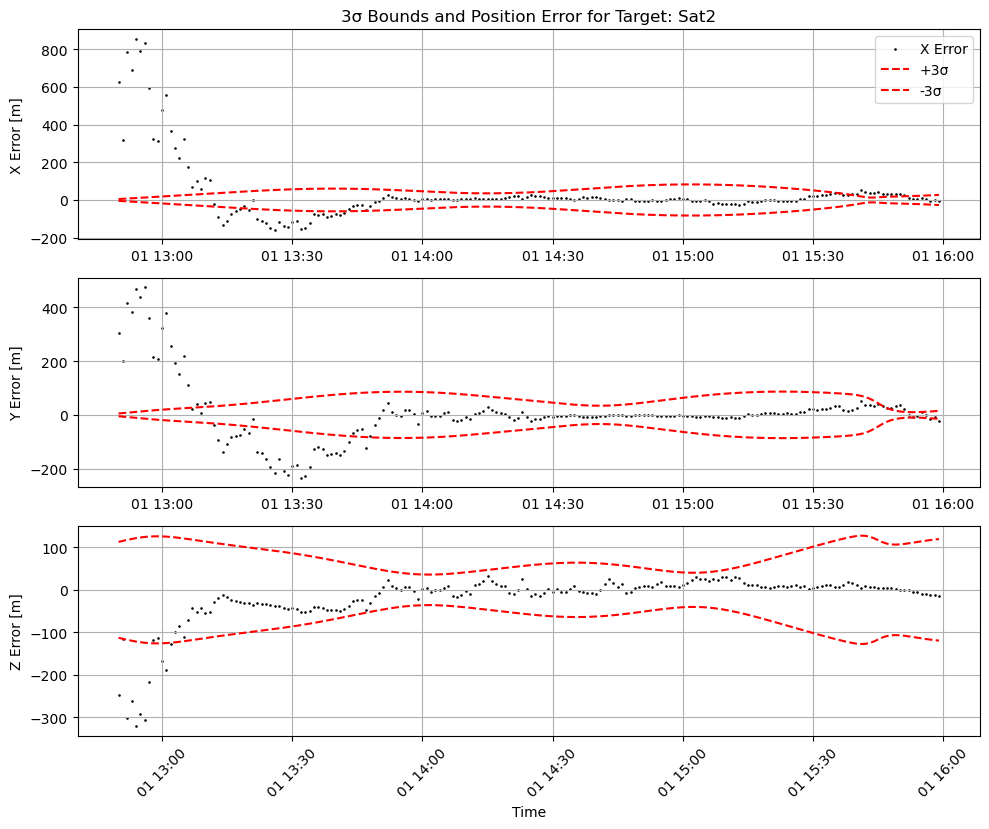

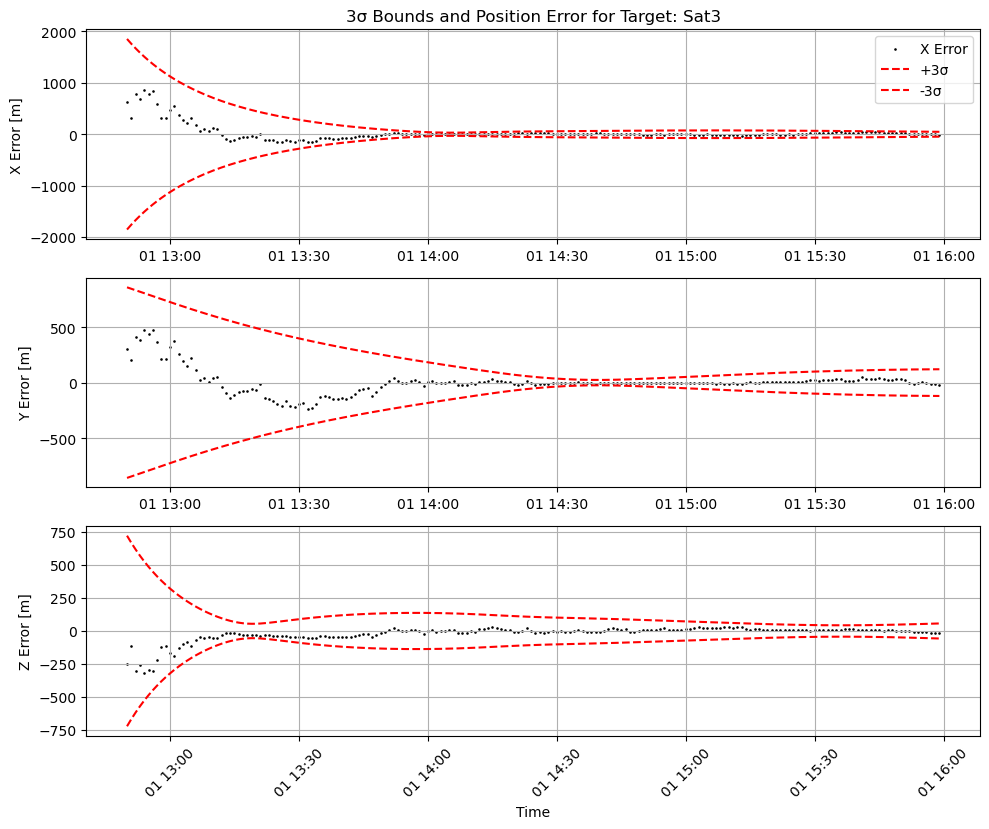

In [6]:
for target in targets:

    cov_array = np.array([est_cov[target][i] for i in idxs])              # shape (N, 6, 6)

    sigma_3 = 3 * np.sqrt(np.array([np.diag(P)[0:3] for P in cov_array])) * 1000 # shape (N, 3)

    x_3sig, y_3sig, z_3sig = sigma_3[:, 0], sigma_3[:, 1], sigma_3[:, 2]

    # Time vector (assumed pre-defined)
    t_plot = times_utc[:]  # or just `idxs` if no time vector

    # Plotting
    plt.figure(figsize=(10, 8))

    for i, (err, sig, label) in enumerate(zip([x_err, y_err, z_err],
                                            [x_3sig, y_3sig, z_3sig],
                                            ['X', 'Y', 'Z'])):
        plt.subplot(3, 1, i + 1)
        plt.scatter(t_plot[50:], err[50:],marker='.',s=3, label=f'{label} Error', color='black')
        plt.plot(t_plot[50:], sig[50:], 'r--', label='+3σ')
        plt.plot(t_plot[50:], -sig[50:], 'r--', label='-3σ')
        # plt.ylim([-1000, 1000])
        plt.ylabel(f'{label} Error [m]')
        plt.grid(True)
        if i == 2:
            plt.xlabel("Time")
        if i == 0:
            plt.title(f"3σ Bounds and Position Error for Target: {target}")
        if i == 0:
            plt.legend()

    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [7]:
# Gravitational parameter of Earth [m^3/s^2]
mu_earth = 398600.4418e9

# # Original state vector [x, y, z, vx, vy, vz] in meters and m/s
# initial_state = 1.0e+06 * np.array([0.7577, 5.222607, 4.8515, 0.00221321, 0.00467834, -0.0053713])

# # Convert Cartesian to Keplerian
# kep_elements = element_conversion.cartesian_to_keplerian(initial_state, mu_earth)

# # Extract original elements
# a, e, i, omega, w, nu = kep_elements
# print("Original Keplerian Elements:")
# print(f"SMA (a): {a/1000:.2f} km\nEccentricity (e): {e:.6f}\nInclination (i): {np.degrees(i):.2f}°")
# print(nu)

# # Define new elements by modifying SMA and inclination
# modifications = [
#     {"da": +5000, "di_deg": +10},   # +5 km, +10°
#     {"da": -50000, "di_deg": -20},   # -50 km, -20°
# ]

# # Container for new states
# new_cartesian_states = []

# for mod in modifications:
#     a_new = a + mod["da"]        # in meters
#     i_new = i + np.radians(mod["di_deg"])  # in radians
#     kep_new = np.array([a_new, e, i_new, omega, w, nu])
    
#     # Convert back to Cartesian
#     cart_new = element_conversion.keplerian_to_cartesian(kep_new, mu_earth)
#     new_cartesian_states.append(cart_new)
#     print("\nModified Keplerian Elements:")
#     print(f"SMA: {a_new/1000:.2f} km, Inclination: {np.degrees(i_new):.2f}°")
#     print("Cartesian state [m, m/s]:", cart_new)

# Access individual results

sat_kep_2 = np.array([10000e3,0.2,np.pi/3,2,4,1])
sat_kep_3 = np.array([15000e3,0.0,np.pi/4,3,1,2])
sat_cart_2 = element_conversion.keplerian_to_cartesian(sat_kep_2,mu_earth)
sat_cart_3 = element_conversion.keplerian_to_cartesian(sat_kep_3,mu_earth)

print(sat_cart_2)
print(sat_cart_3)
# sat2_state = new_cartesian_states[0]
# sat3_state = new_cartesian_states[1]



[ 6.06900255e+06  6.09157542e+06  1.05883186e+06 -1.25648342e+03
  3.83516911e+03 -5.98898761e+03]
[ 1.08574907e+07 -1.91497330e+06 -1.01709279e+07  1.80075931e+03
  4.71821217e+03  1.03397421e+03]
